# Initialization

### Installation

In [1]:
%%capture
!pip install gdown tqdm
!pip install torchvision --quiet
!pip install pykan
!pip install torchmetrics

### Import of libraries

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms import ToPILImage
from torchvision.io import read_image
from torch.utils.data import random_split, DataLoader, Dataset

from torchmetrics.classification import BinaryF1Score
from torchmetrics.classification import BinaryAccuracy
from torchmetrics.classification import BinaryRecall

from kan import KAN

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import os
import gdown
import zipfile
import shutil
from tqdm.notebook import tqdm
import time
from google.colab import drive

import random


### GLOBAL DEFINITIONS

Global variables where there are stored hyperparameters for the training and link, paths for the dataset.

In [87]:
global_var = {
    # Dataset
    'link_download_prefix' : 'https://drive.google.com/uc?export=download&id=YOUR_FILE_ID', # Generic link to download from Drive the file with id "YOUR_FILE_ID"
    "link_dataset": "https://drive.google.com/file/d/10un_W7teXQy9LOB1uqd0e6VJ46UFNRza/view?usp=drive_link0", # The ID is "10un_W7teXQy9LOB1uqd0e6VJ46UFNRza" of the file
    "path_download_dataset": "/content/dataset.zip", # Path of the runtime directory of Colab with the zipped dataset
    "extract_directory": "/content", # Directory where we want to extract the zipped dataset
    "dataset_name": "chest_xray", # Name of the dataset
    "dataset_name_resized": "chest_xray_resized", # Name of the dataset resized
    "dataset_name_resized_augmented": "chest_xray_resized_augmented", # Name of the dataset resized
    "dataset_name_heatmap": "chest_xray_heatmap",
    "dataset_name_gaussian": "chest_xray_gaussian",
    "dataset_name_gaussian_he": "chest_xray_gaussian_he",

    # Preprocessing parameters
    "resizing_dim": 200,
    "colormap_type": cv2.COLORMAP_TWILIGHT,
    "smoothing_value": 5,

    # Network: KAN module
    'input_dim': 10,       # input dimension of KAN
    'hidden_dim': [40, 4], # hidden layers of KAN
    'output_dim': 1,       # output layer, binary classification

    # Train
    'batch_size': 16,
    'epochs': 10,

    # logger parameters
    "log_directory": "/content/log_plots",

    # hyperparamter search
}

In [88]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

### Color Class
This class is used for printing text in different color. In particular each attribute in the Color class corresponds to a specific text color or formatting style.

In [5]:
class Color:
    RED = '\033[91m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    BLUE = '\033[94m'
    MAGENTA = '\033[95m'
    CYAN = '\033[96m'
    WHITE = '\033[97m'
    RESET = '\033[0m' #RESET: Resets all text formatting and color to default
    BOLD = '\033[1m' #BOLD: Makes the text bold
    UNDERLINE = '\033[4m' #UNDERLINE: Underlines the text

Random Seed

# Dataset Setup

## Initial setup


The function, given the link of the dataset in google drive, download it.

Args:
        
1.   **link_dataset** = link to zip files
2.   **delete_zip_file** = {True/False}, use to remove the zip file once extracted the content

Note: the link my be public or gdown can't download it


In [6]:
def download_dataset(link_dataset, delete_zip_file=False):

    # Creating string for download

    link_download_base =  global_var['link_download_prefix'] # General link for the download from Drive (with "YOUR_FILE_ID")
    id_dataset = link_dataset.split("/view")[0].split("/")[-1]
    dataset_download_link = link_download_base.replace("YOUR_FILE_ID", id_dataset) # Replace the "YOUR_FILE_ID" part with the extracted id_dataset

    path_download_dataset = global_var['path_download_dataset'] # Path of the zip file that contain the dataset
    dataset_name = global_var['dataset_name'] # Dataset's Name
    extract_directory = global_var['extract_directory'] # Directory of the GColab Runtime where we want to extract the dataset

    # Downloading zip file
    try:
        if not( os.path.exists(dataset_name) ): # check is the dataset is already downloaded
            gdown.download(
                url=dataset_download_link, # Link that we extract with the file ID
                output=path_download_dataset, # Path of the runtime Colab to save the zip file
                quiet=False # Output to check the download
            )
            print(f"{Color.GREEN}\nZip file downloaded{Color.RESET}")
        else:
            print(f"{Color.GREEN}Zip file already downloaded{Color.RESET} ")
    except Exception as error:
        print(f"{Color.RED}Download went wrong!\nerror:{Color.RESET}")
        print(error)


    # Unzipping the file
    '''
    In this part we want to unzip the zip file contain the dataset
    '''
    try:
        if not( os.path.exists(dataset_name) ):

          # This open the file zip in path_download_dataset in 'r' = read mode.
          # The file is created from the ZipFile class contained in zipfile module
          # and the name of the instance will be zipfile

            with zipfile.ZipFile(path_download_dataset, 'r') as zip_file:

                n_files = len(zip_file.namelist()) # number of files and directories inside the zip

                with tqdm(total=n_files, desc='Unzipping files') as pbar: # It's a bar to track the unzip process, we pass the number of total files
                    for file_name in zip_file.namelist():
                        zip_file.extract(member=file_name, path=extract_directory) # Extract the file_name (iteration over all the files) in the path extract_directory
                        pbar.update(1) # increment the progress bar of 1 unit for each extraction

            print(f"{Color.GREEN}Dataset {dataset_name} unzipped{Color.RESET}")
        else:
            print(f"{Color.GREEN}Dataset {dataset_name} already unzipped{Color.RESET} ")
    except Exception as error:
        print(f"{Color.RED}Unzip went wrong!\nerror:{Color.RESET}")
        print(error)

    # Removing zip file
    '''
    In this part we remove the zip file if the flag
    delete_zip_file is True (args of the function)
    '''
    try:
        if delete_zip_file == True:
            ! rm {path_download_dataset}
            print(f"{Color.GREEN}File {path_download_dataset} removed{Color.RESET}")
    except Exception as error:
        print(f"{Color.RED}Could not remove zip file, pass!\nerror:{Color.RESET}")
        print(error)
        pass

Given the dataset, it merge and shuffle it.

In [7]:
def merge_dataset():

    dataset_name = global_var['dataset_name'] # Name of the directory
    extract_directory = global_var['extract_directory'] # Directory of destination where we put the shuffled dataset
    current_path = os.path.join(extract_directory, dataset_name) # Create the path "/content/chest_xray"
    origin_dataset = os.path.join(current_path,dataset_name) # Create the path "/content/chest_xray/chest_xray"

    # Create a list of this type -> ['/content/chest_xray/train', '/content/chest_xray/test', '/content/chest_xray/val']:
    sub_directory = [ os.path.join(current_path, s) for s in ['train', 'test', 'val']]
    classes = ['PNEUMONIA', 'NORMAL']

    try:
        for sub_dir in sub_directory:

            for c in classes:
                sub_dir_c = os.path.join(sub_dir, c) # Create a path of the type '/content/chest_xray/train/PNEUMONIA' and '/content/chest_xray/train/NORMAL' and so on...
                counter = 0 # This is used for the name of each image

                for img_name in os.listdir(sub_dir_c):
                    counter += 1
                    # Example of img_name:  IM-0001-0001.jpeg

                    # sub_dir.split("/")[-1]: Take the part "train", "test" or "val"
                    # c.lower(): Take the name of the class in uppercase and transform in lowercase
                    # f"_{counter:05d}": put the number counter starting with a zero sequence until 5 numbers sequence
                    # current_name.split(".")[-1]: put the jpeg word at the end
                    # Example of new_name: train_pneumonia_00001.jpeg

                    new_name = sub_dir.split("/")[-1] + "_" + c.lower() + f"_{counter:05d}" + "." + img_name.split(".")[-1]

                    final_path = sub_dir + "/" + new_name # Create a path of the type: /content/chest_xray/train/train_pneumonia_00001.jpeg

                    # Move the file from '/content/chest_xray/train/PNEUMONIA/IM-0001-0001.jpeg' to '/content/chest_xray/train/train_pneumonia_00001.jpeg'
                    # this result in changin the name of the file
                    os.rename( os.path.join(sub_dir_c, img_name), final_path )

                ! rmdir {sub_dir_c} # Remove the empty directory "PNEUMONIA" and "NORMAL" after all rename
        !rm -rf {origin_dataset} # Remove a useless directory

        print(f"{Color.GREEN}Dataset reordered and labelled{Color.RESET}")
    except Exception as error:
        print(f"Dataset already merged\n")
        pass

This function is used to setup the GPU (if there is)

In [8]:
def setup_device():

    """
    Setup device to be used
    """

    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        torch.cuda.set_device(device)
    else:
        device = torch.device("cpu")

    print(f"Current device: {device}")

## Counter Function
This function is used in two options:

1. **labels** = *True* : in this case the counter will count the number of "normal" or "pneumonia" images in the "path_dir"

1. **labels** = *False* : in this case the counter will count simply the number of images in the "path_dir"

In [9]:
def counter (path_dir, labels = True):

  file_list = os.listdir(path_dir) # Create a list of all files in the dataset directory

  if labels == True:

    train_count_normal = 0 # Counter of images "normal"
    train_count_pneumonia = 0 # Counter of images "pneumonia"

  # Iterate through each file in the directory
    for filename in file_list:
        if 'normal' in filename:
            train_count_normal += 1
        elif 'pneumonia' in filename:
            train_count_pneumonia += 1

    return train_count_normal, train_count_pneumonia

  else:

    samples_num = len(file_list);
    return samples_num

# Preprocessing operation on dataset

Given the path for an image, extract a [colormap](https://docs.opencv.org/3.4/d3/d50/group__imgproc__colormap.html) to highlight details

Args:

1. img_originale: images in tensor format


In [10]:
def get_heatmap(img_original):

    colormap_type = global_var['colormap_type']

    # check if the image is on gpu, if yes bring to cpu for use numpy
    if isinstance(img_original, str):
        img_original = cv2.imread(img_original, cv2.IMREAD_GRAYSCALE)
    else:
        if img_original.is_cuda:
            img_original = img_original.cpu()

        img_original = img_original.detach().numpy()
        img_original = np.transpose( img_original, (1,2,0) ) # C, H, W -> H, W, C format
        img_original = cv2.cvtColor(img_original, cv2.COLOR_RGB2GRAY) # get gray-scale image

    img_normalized = cv2.normalize(img_original, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    img_colored = cv2.applyColorMap(img_normalized, colormap_type)
    img_rgb = cv2.cvtColor(img_colored, cv2.COLOR_BGR2RGB)

    return img_rgb

In [11]:
def get_gaussian(img_original):

    img_original = cv2.imread(img_original, cv2.IMREAD_GRAYSCALE)

    smoothing_value = global_var['smoothing_value']
    img_smoothed = cv2.GaussianBlur( img_original, ( smoothing_value, smoothing_value), 0 )

    return img_smoothed

In [12]:
def get_gaussian_he(img_original):

    img_original = cv2.imread(img_original, cv2.IMREAD_GRAYSCALE)

    smoothing_value = global_var['smoothing_value']
    img_smoothed = cv2.GaussianBlur( img_original, ( smoothing_value, smoothing_value), 0 )
    img_eq = cv2.equalizeHist(img_smoothed )

    return img_eq

This function will do a "downsampling" or "upsampling" technique given an image (tensor) in input, depending on the new requested size.

Args:

1. **mode** : the mode of [interpolation](https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html) like 'nearest', 'bilinear', 'bicubic' ...
2. **size** : the new size, like (800x800)

In [13]:
def resize_and_save(mode, size):

    original_dataset = global_var['dataset_name'] # Name of the original dataset
    resized_dataset = global_var['dataset_name_resized'] # Name of the resized dataset

    extract_directory = global_var['extract_directory'] # Directory of the GColab Runtime where we want to extract the dataset
    original_path = os.path.join(extract_directory, original_dataset) # Create the path "/content/chest_xray"
    resized_path = os.path.join(extract_directory, resized_dataset) # Create the path "/content/chest_xray_resized"

    # Create a list of this type -> ['/content/chest_xray/train', '/content/chest_xray/test', '/content/chest_xray/val']:
    sub_directory_original = [ os.path.join(original_path, s) for s in ['train', 'test', 'val']]

    try:
      for sub_dir in sub_directory_original:
        category = os.path.basename(sub_dir) # Extract the part 'train', 'test' or 'val'

        # Copy from source to destination
        source_dir = sub_dir # Source Directory (Ex. '/content/chest_xray/train')
        destination_dir = resized_path + '/' + category # Destination Directory ('Ex. /content/chest_xray_resized/train')

        if not(os.path.exists(destination_dir)):
          # Copy the entire directory
          shutil.copytree(source_dir, destination_dir)

          # Loop for the resizing and save
          img_files = os.listdir(sub_dir)
          for img in tqdm(img_files, desc=f"Resizing {category} images", unit="image"):

            # Take the name and extension of the image
            name, extension = os.path.splitext(img)

            # Read the image
            img_path = sub_dir + '/' + name + extension
            img = read_image(img_path) # Tensor Image (Ex. torch.Size([1, 928, 1288]))

            # Add a batch dimensione of 1 needed for the nn.functional.interpolate method
            img_4d = img.unsqueeze(0) # Tensor Image (Ex. torch.Size([1, 1, 928, 1288]))

            # Interpolation method
            resized_image = nn.functional.interpolate(img_4d, size=size, mode=mode) # Tensor Image (Ex. torch.Size([1, 1, 800, 800]))

            # Remove the batch dimension
            resized_image = resized_image.squeeze(0)  # Tensor Image (Ex. torch.Size([1, 800, 800]))

            # Permute the dimensions
            resized_image = resized_image.permute(1, 2, 0) # Tensor Image (Ex. torch.Size([800, 800, 1]))

            # Transform in numpy structure
            resized_image = resized_image.numpy() # Numpy Image (Ex. (800, 800, 1))

            # Convert to PIL image using torchvision.transforms
            to_pil = ToPILImage() # Transformer Numpy -> PIL Image
            resized_image_pil = to_pil(resized_image) # PIL Image

            # Save the resulting image
            path_to_save = destination_dir + '/' + name + extension # Path of the type '/content/chest_xray_resized/train/img_name.jpeg'
            resized_image_pil.save(path_to_save) # Function to save the image
        else:
          print(f"{Color.GREEN}Data for {category} already resized{Color.RESET} ")

    except Exception as error:
      print(f"Problem in resizing\n")
      print(error)
      pass

In [14]:
def data_augmentation(transform):

    tr = transform # Transform that we use for augment the data of the training set
    original_dataset = global_var['dataset_name_resized'] # Name of the original dataset
    new_dataset = global_var['dataset_name_resized_augmented'] # Name of the resized dataset

    extract_directory = global_var['extract_directory'] # Directory of the GColab Runtime where we want to extract the dataset
    original_path = os.path.join(extract_directory, original_dataset) # Create the path "/content/chest_xray_resized"
    new_path = os.path.join(extract_directory, new_dataset) # Create the path "/content/chest_xray_resized_augmented"

    # Create a list of this type -> ['/content/chest_xray_resized/train', '/content/chest_xray_resized/test', '/content/chest_xray_resized/val']:
    sub_directory_original = [ os.path.join(original_path, s) for s in ['train', 'test', 'val']]
    # Create a list of this type -> ['/content/chest_xray_resized_augmented/train', '/content/chest_xray_resized_augmented/test', '/content/chest_xray_resized_augmented/val']:
    sub_directory_augmented = [ os.path.join(new_path, s) for s in ['train', 'test', 'val']]

    try:
      for sub_dir in sub_directory_original:
        category = os.path.basename(sub_dir) # Extract the part 'train', 'test' or 'val'

        # Copy from source to destination
        source_dir = sub_dir # Source Directory ('Ex. /content/chest_xray_resized/train')
        destination_dir = new_path + '/' + category # Destination Directory ('Ex. /content/chest_xray_resized_augmented/train')

        if not(os.path.exists(destination_dir)):
          # Copy the entire directory
          shutil.copytree(source_dir, destination_dir)
        else:
          print(f"{Color.GREEN}Data for {category} already copied{Color.RESET} ")
          return

    except Exception as error:
      print(f"Problem in copying\n")
      print(error)
      pass

    try:
      dir_train = sub_directory_augmented[0]                   # '/content/chest_xray_resized_augmented/train'
      img_files_train = os.listdir(dir_train)                  # List of all training images
      n_normal, n_pneumonia = counter(dir_train, labels=True)  # Count the number of normal and pneumonia images
      difference = n_pneumonia - n_normal                      # Desired value of augmented images
      sub_path = os.path.join(dir_train, '/augmented')         # Subdirectory where we save the augmented images
      !mkdir {dir_train + '/augmented/'}                       # Create the subdirectory
      actual = len(os.listdir(dir_train + '/augmented/'))      # Actual value of augmented images

      n = 0                                                    # Counter used to name the augmented images

      with tqdm(total=difference, desc='Augmenting data') as pbar:
        while  actual < difference:
          img = random.choice(img_files_train)           # Pick a random image file from the list
          if ('normal' in img):
            n += 1
            # Take the name and extension of the image
            name, extension = os.path.splitext(img)

            # Read the image as a Tensor
            img = read_image(dir_train + '/' + img)

            # Transform the image
            new_image = transform(img); # Transformed Tensor Image

            # Permute the dimensions
            new_image = new_image.permute(1, 2, 0) # Tensor Image (Ex. torch.Size([800, 800, 1]))

            # Transform in numpy structure
            new_image = new_image.numpy() # Numpy Image (Ex. (800, 800, 1))

            # Convert to PIL image using torchvision.transforms
            to_pil = ToPILImage() # Transformer Numpy -> PIL Image
            new_image_pil = to_pil(new_image) # PIL Image

            # Save the resulting image:  Path of the type /content/chest_xray_resized_augmented/train/augmented/train_normal_00001_augmented.jpeg
            path_to_save = dir_train + '/augmented/' + name.split('_')[0] + '_' + name.split('_')[1] + f"_{n:05d}" + '_augmented' + extension
            new_image_pil.save(path_to_save) # Function to save the image
            actual += 1     # Update of Actual value of agumented images
            pbar.update(1)

      for img_name in os.listdir(dir_train + '/augmented/'):
        final_path = dir_train + '/' # Create a path of the type: /content/chest_xray_resized_augmented/train/
        os.rename(dir_train + '/augmented/' + img_name, final_path + img_name)

      !rmdir {dir_train + '/augmented/'} # Remove the empty directory "PNEUMONIA" and "NORMAL" after all rename

    except Exception as error:
        print(f"Problem in augmenting\n")
        print(error)
        pass

In [15]:
def preprocess_image(image_global_path, mode):

    # based of the selected mode, it does a preprocess on image
    # returun None is something went wrong

    if mode == 'heatmap':
        preprocessed_img = get_heatmap( image_global_path )
    elif mode == 'gaussian':
        preprocessed_img = get_gaussian( image_global_path )
    elif mode == 'gaussian_he':
        preprocessed_img = get_gaussian_he( image_global_path )
    else:
        print(f"{Color.RED}Preprocessing {mode} is not available{Color.RESET}")
        ! rm -rf {new_dataset_path}

        preprocessed_img = None

    return preprocessed_img

In [16]:
def create_preprocessed_dataset( dataset_path, new_dataset_path, mode ):

    categories = ['val', 'test', 'train']
    mode = mode.lower()

    if os.path.exists(new_dataset_path):
        print(f"{Color.GREEN}Dataset {new_dataset_path} images already exists{Color.RESET}")
        return
    else:
        ! cp -r {dataset_path} {new_dataset_path}   # coping augmented dataset "/content/chest_xray_{mode}"

    for c in categories:  # iterate on train, test, val

        n_files = len( os.listdir( os.path.join(new_dataset_path, c ) ) )   # it is "/content/chest_xray_{mode}/train,test,val"

        with tqdm(total=n_files, desc='Processing ' + c) as pbar:
            for img_path in os.listdir( os.path.join(dataset_path, c) ):   # iterate on train, test, val of heatmap dataset

                full_img_path = new_dataset_path + "/" + c + "/" + img_path # global path to image

                preprocessed_img = preprocess_image(full_img_path, mode)    # preprocess the image according the the selected mode

                if "augmented" in img_path:
                    new_name = img_path.replace("augmented", mode)   # renaming the images
                else:
                    new_name = img_path.replace(".", f"_{mode}.")

                #print(new_name)
                new_full_path = full_img_path.replace(img_path, new_name)  # /content/chest_xray_heatmap/train/test_normal_00001_heatmap.jpeg

                cv2.imwrite(full_img_path, preprocessed_img) # overwrite the image
                os.rename(full_img_path, new_full_path) # renaming the image

                pbar.update(1)

# Dataset and Network classes

## ChestRayDataset

In [53]:
class ChestRayDataset(Dataset):

    def __init__(self,file_path, transform):
        self.file_path = file_path
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.file_path))

    def __getitem__(self, index):
        sample_path = self.file_path + "/" + os.listdir(self.file_path)[index]
        sample = cv2.imread(sample_path)
        sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)

        # Output of the class
        sample_tensor = self.transform(sample)
        label = sample_path.split("/")[-1].split("_")[1]

        if label == "normal":
            label = 0
        else:
            label = 1

        return sample_tensor,label

## Architecture

Metrics used are

*   [BinaryAccuracy](https://lightning.ai/docs/torchmetrics/stable/classification/accuracy.html): to evaluate how much correct predictions the network does
*   [BinaryRecall](https://lightning.ai/docs/torchmetrics/stable/classification/recall.html): in medical field it is important to avoid false negative so avoid to classify a radiography with diseased lungs as healty
*   [BinaryF1Score](https://lightning.ai/docs/torchmetrics/stable/classification/f1_score.html): used to computed average of precision and recall, used to evaluate overall performance







Riferimento per cnn in [Medical classification](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7778711/)

In [68]:
class JAM_network(nn.Module):
    def __init__(self, input_dim, out_channels, kernel_size, bias, stride=1, padding='valid'):
        super(JAM_network,self).__init__()

        self.sigm = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d( kernel_size=kernel_size )

        # two branch CNN
        self.conv1 = nn.Conv2d(in_channels=input_dim, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels//2, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv3 = nn.Conv2d(in_channels=out_channels//2, out_channels=out_channels//4, kernel_size=kernel_size, stride=stride, padding=padding)

        self.linear_projection = nn.Linear(in_features=288, out_features=64, bias=bias)

        self.kan = KAN(width=[64, 32, 1], device=device)
        self.kan.to(device)

    def forward(self, network_input):

        # first branch
        out_c1 = self.conv1( network_input )
        out_c1 = self.max_pool( out_c1 )
        #print(out_c1.shape)

        out_c2 = self.conv2( out_c1 )
        out_c2 = self.max_pool( out_c2 )
        #print(out_c2.shape)

        out_c3 = self.conv3( out_c2 )
        out_c3 = self.max_pool( out_c3 )
        #print(out_c3.shape)

        # linear projection
        flat_out_c3 = out_c3.view(out_c3.size(0), -1)   # flatten
        l_proj = self.linear_projection( flat_out_c3 )
        l_proj = self.relu( l_proj )

        # KAN classification
        out_kan = self.kan( l_proj ) #+ l_proj_d )
        logits = self.sigm(out_kan)

        return logits

In [69]:
class JAM(nn.Module):
    def __init__(self, input_dim, out_channels, kernel_size, bias, model_name):
        super().__init__()

        self.model = JAM_network(
            input_dim=input_dim,
            out_channels=out_channels,
            kernel_size=kernel_size,
            bias=bias
            )

        self.loss_fn = nn.BCELoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=0.1)

        self.accuracy = BinaryAccuracy()
        self.recall = BinaryRecall()
        self.f1score = BinaryF1Score()

        self.model_name = model_name

    def forward(self, model_input):
        return self.model(model_input)

    def save(self):
        name = self.model_name
        torch.save(self.state_dict(), name )
        #print(f"{Color.MAGENTA}Saved: {name}{Color.RESET}")

    def load(self):
        name = self.model_name
        try:
            self.load_state_dict(torch.load(name) )
            print(f"{Color.MAGENTA}loaded: {name}{Color.RESET}")
        except Exception as e:
            print(f"{Color.RED}Model not loaded{Color.RESET}")
            print(e)

# Dataset informations

## Download and merge of the dataset

In [20]:
download_dataset(
     link_dataset=global_var['link_dataset'],
     delete_zip_file=False
 )

merge_dataset()

Downloading...
From (original): https://drive.google.com/uc?export=download&id=10un_W7teXQy9LOB1uqd0e6VJ46UFNRza
From (redirected): https://drive.google.com/uc?export=download&id=10un_W7teXQy9LOB1uqd0e6VJ46UFNRza&confirm=t&uuid=d3aad3d8-868d-474e-b84f-34d09db21473
To: /content/dataset.zip
100%|██████████| 2.46G/2.46G [01:00<00:00, 41.0MB/s]



Zip file downloaded


Unzipping files:   0%|          | 0/17591 [00:00<?, ?it/s]

Dataset chest_xray unzipped
Dataset reordered and labelled


In [21]:
size = global_var["resizing_dim"] # Choose the size

resize_and_save(
    mode='bilinear',    # Choose the mode of interpolation ('nearest', 'bilinear', 'bicubic', ...)
    size=(size, size)
)

Resizing train images:   0%|          | 0/5216 [00:00<?, ?image/s]

Resizing test images:   0%|          | 0/624 [00:00<?, ?image/s]

Resizing val images:   0%|          | 0/16 [00:00<?, ?image/s]

In [22]:
tr_augmentation = transforms.Compose([
     #transforms.RandomHorizontalFlip(0.8),
     #transforms.RandomVerticalFlip(0.2),
     transforms.ColorJitter(brightness=0.4),
     #transforms.RandomRotation(degrees=(90,90)),
])

data_augmentation(tr_augmentation)

Augmenting data:   0%|          | 0/2534 [00:00<?, ?it/s]

In [23]:
dataset_directory = global_var["extract_directory"] + "/" + global_var["dataset_name_resized_augmented"]
heatmap_directory = global_var["extract_directory"] + "/" + global_var["dataset_name_heatmap"]

create_preprocessed_dataset(
    dataset_path = dataset_directory,
    new_dataset_path = heatmap_directory,
    mode = 'heatmap'
)

Processing val:   0%|          | 0/16 [00:00<?, ?it/s]

Processing test:   0%|          | 0/624 [00:00<?, ?it/s]

Processing train:   0%|          | 0/7750 [00:00<?, ?it/s]

In [89]:
dataset_directory = global_var["extract_directory"] + "/" + global_var["dataset_name_resized_augmented"]
gaussian_directory = global_var["extract_directory"] + "/" + global_var["dataset_name_gaussian"]

create_preprocessed_dataset(
    dataset_path = dataset_directory,
    new_dataset_path = gaussian_directory,
    mode = 'gaussian'
)

Processing val:   0%|          | 0/16 [00:00<?, ?it/s]

Processing test:   0%|          | 0/624 [00:00<?, ?it/s]

Processing train:   0%|          | 0/7750 [00:00<?, ?it/s]

In [24]:
dataset_directory = global_var["extract_directory"] + "/" + global_var["dataset_name_resized_augmented"]
gaussian_he_directory = global_var["extract_directory"] + "/" + global_var["dataset_name_gaussian_he"]

create_preprocessed_dataset(
    dataset_path = dataset_directory,
    new_dataset_path = gaussian_he_directory,
    mode = 'gaussian_he'
)

Processing val:   0%|          | 0/16 [00:00<?, ?it/s]

Processing test:   0%|          | 0/624 [00:00<?, ?it/s]

Processing train:   0%|          | 0/7750 [00:00<?, ?it/s]

## Dataset exploration, augmentation and visualization

In this part we plot an:

1. *Histogram Distribution* : to see if the dataset is balanced or unbalanced

2. *Pie Chart* : to visualize the sizes of training, test and validation sets

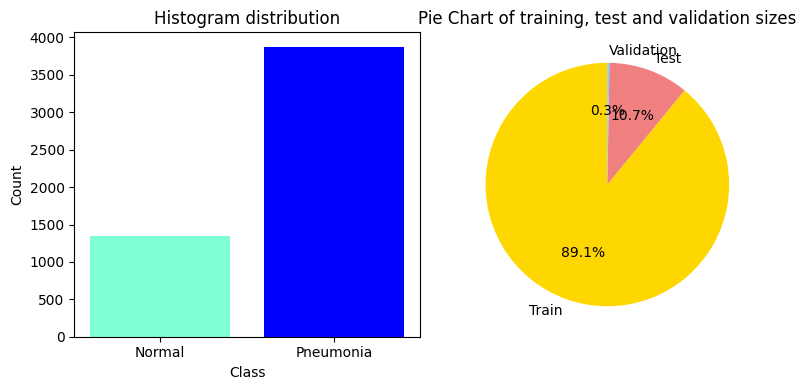


The number of training images: 5216
The number of test images: 624
The number of validation images: 16


In [25]:
# @title Initial statistic of dataset
# Definition of the paths for training, test and validation set
path_training_set = "/content/chest_xray/train"
path_test_set = "/content/chest_xray/test"
path_val_set = "/content/chest_xray/val"

# Counting the Normal and Pneumonia images in the training set
train_norm, train_pneu = counter(path_training_set, labels = True); # Count the number of normal images and pneumonia images

train_num = counter(path_training_set, labels = False);
test_num = counter(path_test_set, labels = False);
val_num = counter(path_val_set, labels = False);

# Histogram Data
classes_hist = ['Normal', 'Pneumonia']
counts_hist = [train_norm, train_pneu]
colors_hist = ['aquamarine', 'blue']

# Pie Chart Data
classes_pie = ['Train', 'Test', 'Validation']
counts_pie = [train_num, test_num, val_num]
colors_pie = ['gold', 'lightcoral', 'lightskyblue']

# Create a figure with specific dimensions and subplots
fig, ax = plt.subplots(1, 2, figsize=(8, 4))  # Adjust figsize as needed

# Plotting the histogram
ax[0].bar(classes_hist, counts_hist, color=colors_hist)
ax[0].set_title('Histogram distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')

# Plotting the pie chart
ax[1].pie(counts_pie, labels=classes_pie, colors=colors_pie, autopct='%1.1f%%', startangle=90)
ax[1].set_title('Pie Chart of training, test and validation sizes')

plt.tight_layout()  # This adjusts subplot params so that the subplots fit into the figure area.
plt.show()

print("\nThe number of training images:", train_num)
print("The number of test images:", test_num)
print("The number of validation images:", val_num)



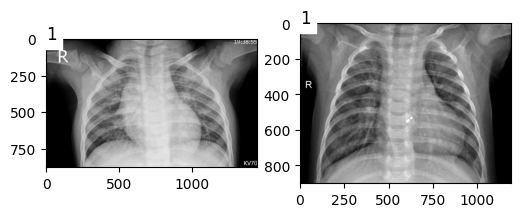

In [26]:
# @title Visualization of two random images
# Define a transform element to resize the images as square images and transform in Tensor
tr_1 = transforms.ToTensor()                # Convert the image to a tensor

# Definition of the paths for training, test and validation set
path_training_set = "/content/chest_xray/train"
path_test_set = "/content/chest_xray/test"
path_val_set = "/content/chest_xray/val"

# Instance of classes for the Dataset
train_dataset = ChestRayDataset(path_training_set, tr_1) # Create an instance of training class
test_dataset = ChestRayDataset(path_test_set, tr_1) # Create an instance of test class
val_dataset = ChestRayDataset(path_val_set, tr_1) # Create an instance of validation class

# Generate two random numbers to select two random images from training set
random_num_1 = np.random.randint(1, len(train_dataset))
random_num_2 = np.random.randint(1, len(train_dataset))

# Take an image + label randomly
img_1, label_1 = train_dataset[random_num_1]
img_2, label_2 = train_dataset[random_num_2]

# Display the image using matplotlib library
plt.figure( figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(img_1.permute(1, 2, 0))
plt.axis('on')
plt.text(0, 0, label_1, fontsize=12, color='black', backgroundcolor='white')

plt.subplot(1,2,2)
plt.imshow(img_2.permute(1, 2, 0))
plt.axis('on')
plt.text(0, 0, label_2, fontsize=12, color='black', backgroundcolor='white')

plt.show()

print ("The shape of the first image is: ", img_1.permute(1, 2, 0).shape)
print ("The shape of the second image is: ", img_2.permute(1, 2, 0).shape)

The shape of the first image is:  torch.Size([880, 1448, 3])
The shape of the second image is:  torch.Size([901, 1190, 3])


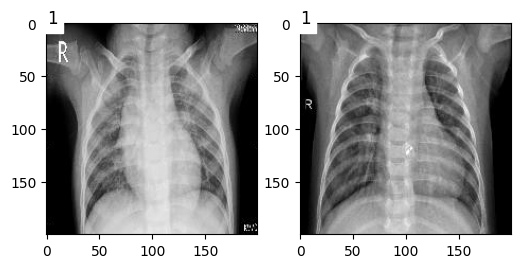

The shape of the first image is:  torch.Size([200, 200, 3])
The shape of the second image is:  torch.Size([200, 200, 3])


In [27]:
# @title Squarring

# Define a transform element to resize the images as square images and transform in Tensor
tr_1 = transforms.ToTensor()                 # Convert the image to a tensor

# Definition of the paths for training, test and validation set
path_training_set_resized = "/content/chest_xray_resized/train"
path_test_set_resized = "/content/chest_xray_resized/test"
path_val_set_resized = "/content/chest_xra_resized/val"

# Instance of classes for the Dataset
train_dataset_resized = ChestRayDataset(path_training_set_resized, tr_1) # Create an instance of training class
test_dataset_resized = ChestRayDataset(path_test_set_resized, tr_1) # Create an instance of test class
val_dataset_resized = ChestRayDataset(path_val_set_resized, tr_1) # Create an instance of validation class

# Take an image + label randomly
img_1, label_1 = train_dataset_resized[random_num_1]
img_2, label_2 = train_dataset_resized[random_num_2]

# Display the image using matplotlib library
plt.figure( figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(img_1.permute(1, 2, 0))
plt.axis('on')
plt.text(0, 0, label_1, fontsize=12, color='black', backgroundcolor='white')

plt.subplot(1,2,2)
plt.imshow(img_2.permute(1, 2, 0))
plt.axis('on')
plt.text(0, 0, label_2, fontsize=12, color='black', backgroundcolor='white')

plt.show()

print ("The shape of the first image is: ", img_1.permute(1, 2, 0).shape)
print ("The shape of the second image is: ", img_2.permute(1, 2, 0).shape)

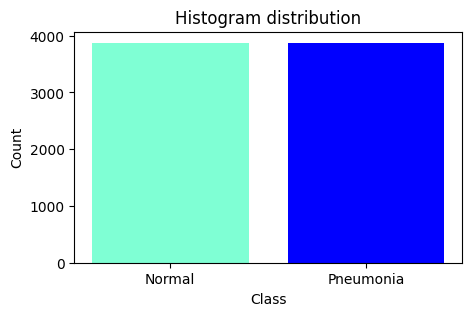

The number of normal images: 3875
The number of pneumonia images: 3875


In [28]:
# @title Statistics after data augmentation
# Definition of the paths for training, test and validation set
path_training_set_resized_augmented = "/content/chest_xray_resized_augmented/train"

# Counting the Normal and Pneumonia images in the training set
train_norm, train_pneu = counter(path_training_set_resized_augmented, labels = True); # Count the number of normal images and pneumonia images

# Histogram Data
classes_hist = ['Normal', 'Pneumonia']
counts_hist = [train_norm, train_pneu]
colors_hist = ['aquamarine', 'blue']


plt.figure(figsize=(5, 3))
plt.bar(classes_hist, counts_hist, color=colors_hist)
plt.title('Histogram distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

print("The number of normal images:", train_norm)
print("The number of pneumonia images:", train_pneu)



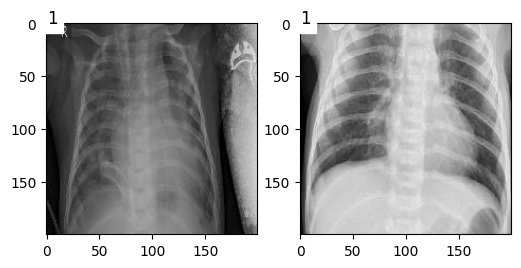

In [29]:
# @title Visualization of two sample is augmented dataset
# Instance of classes for the Dataset
train_dataset_resized_augmented = ChestRayDataset(path_training_set_resized_augmented, tr_1) # Create an instance of training class

# Generate two random numbers to select two random images from training set
random_num_1 = np.random.randint(1, len(train_dataset_resized_augmented))
random_num_2 = np.random.randint(1, len(train_dataset_resized_augmented))

# Take an image + label randomly
img_1, label_1 = train_dataset_resized_augmented[random_num_1]
img_2, label_2 = train_dataset_resized_augmented[random_num_2]

# Display the image using matplotlib library
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(img_1.permute(1, 2, 0))
plt.axis('on')
plt.text(0, 0, label_1, fontsize=12, color='black', backgroundcolor='white')

plt.subplot(1,2,2)
plt.imshow(img_2.permute(1, 2, 0))
plt.axis('on')
plt.text(0, 0, label_2, fontsize=12, color='black', backgroundcolor='white')

plt.show()

0
torch.Size([3, 200, 200])


(-0.5, 199.5, 199.5, -0.5)

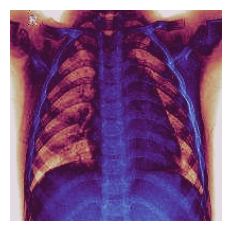

In [30]:
# @title Heatmap visualization - normal
path_train_heatmap = global_var["extract_directory"] + "/" + global_var["dataset_name_heatmap"] + "/train"
train_dataset_heatmap = ChestRayDataset(path_train_heatmap, tr_1)

normal_img, label_1  = train_dataset_heatmap[110] #"chest_xray/test/train_normal_00001.jpeg"
print(label_1)
print(normal_img.shape)

plt.figure( figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow( np.transpose(normal_img, (1,2,0)), cmap='gray')
plt.axis('off')

#plt.subplot(1,2,2)
#plt.imshow(processed_img)
plt.axis('off')

0
torch.Size([3, 200, 200])


(-0.5, 199.5, 199.5, -0.5)

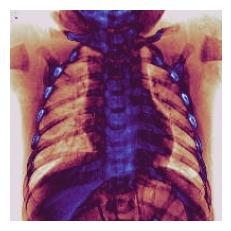

In [31]:
# @title Heatmap visualization - pneumonia
normal_img, label_2  = train_dataset_heatmap[100]
print(label_2)
print(normal_img.shape)

plt.figure( figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(np.transpose(normal_img, (1,2,0)), cmap='gray')
plt.axis('off')

#plt.subplot(1,2,2)
#plt.imshow(np.transpose(normal_img, (1,2,0)))
plt.axis('off')

# Training

Training loop from [documentation](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html)

In [78]:
def calculate_metrics(model, outputs, labels ):

    accuracy_value = model.accuracy(outputs, labels)
    recall_value = model.recall(outputs, labels)
    f1score_value = model.f1score(outputs, labels)

    metrics_string = f"\n\taccuracy: {accuracy_value:.2f}, recall: {recall_value:.2f}, f1score: {f1score_value:.2f}"
    print(metrics_string)
    return

In [79]:
def train_one_epoch(model, epoch_index, training_loader):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting

    n_batch = len(training_loader)  # number of batches in training loader
    batch_size = global_var['batch_size']
    n_files = n_batch*batch_size

    with tqdm(total=n_files, desc=f'Epoch {epoch_index+1} ') as pbar:
        for i, data in enumerate(training_loader):

            # Every data instance is an input + label pair
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            labels = labels.unsqueeze(dim=1)     # reshaping as inputs, from [0, 1] to [[0], [1]]
            labels = labels.type(torch.float32)  # preditions of network are floats

            # Zero your gradients for every batch!
            model.optimizer.zero_grad()

            # Make predictions for this batch
            outputs = model(inputs)

            # Compute the loss and its gradients
            loss = model.loss_fn(outputs, labels)
            loss.backward()

            # Adjust learning weights
            model.optimizer.step()

            # Gather data and report
            running_loss += loss.item()

            if i % batch_size == 0:
                last_loss = running_loss / 1000 # loss per batch
                print(f'\r\tbatch {i+1} loss: {last_loss}', end='')
                running_loss = 0.

            pbar.update(labels.shape[0])

    return last_loss

In [109]:
def training(model, epochs, training_loader, validation_loader):

    best_vloss = 1000000
    epoch_number = 0

    for epoch in range(epochs):
        #print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        # model.train(True)
        avg_loss = train_one_epoch(model, epoch, training_loader)

        running_vloss = 0.0

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(validation_loader):
                vinputs, vlabels = vdata

                vinputs = vinputs.to(device)
                vlabels = vlabels.to(device)

                vlabels = vlabels.unsqueeze(dim=1)    # [0, 1, 0, 1] -> [[0], [1], [0], [1]]
                vlabels = vlabels.type(torch.float32)

                voutputs = model(vinputs)
                vloss = model.loss_fn(voutputs, vlabels)

                running_vloss += vloss

                calculate_metrics(model, voutputs, vlabels)


        avg_vloss = running_vloss / ( i + 1 )
        print(f"\taverage loss train: {avg_loss:.4f}, average loss validation: {avg_vloss:.4f}\n")

        if avg_vloss < best_vloss:
            best_vloss = avg_loss
            model_path = model.model_name #f'/content/model_{epoch_number}'
            torch.save(model.state_dict(), model_path)

In [81]:
def test(model, test_loader):

    running_tloss = 0

    n_batch = len(test_loader)  # number of batches in training loader
    batch_size = global_var['batch_size']
    n_files = n_batch*batch_size

    with tqdm(total=n_files, desc=f'Testing ') as pbar:

        with torch.no_grad():
            for i, tdata in enumerate(test_loader):

                tinputs, tlabels = tdata

                tinputs = tinputs.to(device)
                tlabels = tlabels.to(device)

                tlabels = tlabels.unsqueeze(dim=1)    # [0, 1, 0, 1] -> [[0], [1], [0], [1]]
                tlabels = tlabels.type(torch.float32)

                if i == 0:
                    outputs_tensor = torch.empty(0, tlabels.shape[1])
                    labels_tensor = torch.empty(0, tlabels.shape[1])

                toutputs = model(tinputs)
                tloss = model.loss_fn(toutputs, tlabels)

                running_tloss += tloss

                outputs_tensor = torch.cat((outputs_tensor, toutputs), dim=0)
                labels_tensor = torch.cat((labels_tensor, tlabels), dim=0)

                pbar.update(tlabels.shape[0])

            calculate_metrics(model, outputs_tensor, labels_tensor)

## Preprocessing: heatmap

In [102]:
device

'cpu'

### First step: creation of dataset instance and dataloaders for each step of a training process regarding to a neural network

In [103]:
tf_to_tensor = transforms.ToTensor()

heatmap_train_path = global_var['extract_directory'] + "/" + global_var['dataset_name_heatmap'] + '/train'
heatmap_test_path = global_var['extract_directory'] + "/" + global_var['dataset_name_heatmap'] + '/test'
heatmap_val_path = global_var['extract_directory'] + "/" + global_var['dataset_name_heatmap'] + '/val'

In [104]:
heatmap_train_dataset = ChestRayDataset(
    file_path= heatmap_train_path,
    transform=tf_to_tensor
)

heatmap_test_dataset = ChestRayDataset(
    file_path= heatmap_test_path,
    transform=tf_to_tensor
)

heatmap_val_dataset = ChestRayDataset(
    file_path= heatmap_val_path,
    transform=tf_to_tensor
)

In [105]:
batch_size = global_var["batch_size"]

heatmap_train_dataloader = DataLoader(
    heatmap_train_dataset,
    batch_size=batch_size,
    shuffle=True
    )

heatmap_test_dataloader = DataLoader(
    heatmap_test_dataset,
    batch_size=batch_size,
    shuffle=True
    )

heatmap_val_dataloader = DataLoader(
    heatmap_val_dataset,
    batch_size=batch_size,
    shuffle=True
    )

### Second step: train network and evaluation

In [106]:
jam_network_heatmap = JAM(
            input_dim=3,
            out_channels=32,
            kernel_size=3,
            bias=True,
            model_name=global_var['extract_directory'] + "/" + "jam_network_heatmap.pt"
        )

jam_network_heatmap.to(device)

sample = heatmap_train_dataset[0][0].unsqueeze(0).to(device)
label = heatmap_train_dataset[0][1]

t_now = time.time()
jam_network_heatmap(sample)

#jam_network.model.kan.plot()
training(jam_network_heatmap, 3, heatmap_train_dataloader, heatmap_val_dataloader)

Epoch 1 :   0%|          | 0/6416 [00:00<?, ?it/s]

	batch 401 loss: 0.0035183369033038618
	accuracy: 0.94, recall: 1.00, f1score: 0.94
	average loss train: 0.0035, average loss validation: 0.3725



Epoch 2 :   0%|          | 0/6416 [00:00<?, ?it/s]

	batch 401 loss: 0.0016024372018873692
	accuracy: 0.88, recall: 1.00, f1score: 0.89
	average loss train: 0.0016, average loss validation: 0.2914



Epoch 3 :   0%|          | 0/6416 [00:00<?, ?it/s]

	batch 401 loss: 0.0022638321155682207
	accuracy: 0.81, recall: 1.00, f1score: 0.84
	average loss train: 0.0023, average loss validation: 0.3828



In [107]:
jam_network_heatmap.save()

In [108]:
test(jam_network_heatmap, heatmap_test_dataloader)

Testing :   0%|          | 0/624 [00:00<?, ?it/s]


	accuracy: 0.75, recall: 0.98, f1score: 0.83


## Preprocessing: Gaussian blur + histogram equalization

In [70]:
device

'cpu'

### First step: creation of dataset instance and dataloaders for each step of a training process regarding to a neural network

In [71]:
tf_to_tensor = transforms.ToTensor()

gaussian_he_train_path = global_var['extract_directory'] + "/" + global_var['dataset_name_gaussian_he'] + '/train'
gaussian_he_test_path = global_var['extract_directory'] + "/" + global_var['dataset_name_gaussian_he'] + '/test'
gaussian_he_val_path = global_var['extract_directory'] + "/" + global_var['dataset_name_gaussian_he'] + '/val'

In [72]:
gaussian_he_train_dataset = ChestRayDataset(
    file_path= gaussian_he_train_path,
    transform=tf_to_tensor
)

gaussian_he_test_dataset = ChestRayDataset(
    file_path= gaussian_he_test_path,
    transform=tf_to_tensor
)

gaussian_he_val_dataset = ChestRayDataset(
    file_path= gaussian_he_val_path,
    transform=tf_to_tensor
)

In [73]:
batch_size = global_var["batch_size"]

gaussian_he_train_dataloader = DataLoader(
    gaussian_he_train_dataset,
    batch_size=batch_size,
    shuffle=True
    )

gaussian_he_test_dataloader = DataLoader(
    gaussian_he_test_dataset,
    batch_size=batch_size,
    shuffle=True
    )

gaussian_he_val_dataloader = DataLoader(
    gaussian_he_val_dataset,
    batch_size=batch_size,
    shuffle=True
    )

### Second step: train network and evaluation

In [82]:
jam_network_gaussian_he = JAM(
            input_dim=3,
            out_channels=32,
            kernel_size=3,
            bias=True,
            model_name=global_var['extract_directory'] + "/" + "jam_network_gaussian_he.pt"
        )

jam_network_gaussian_he.to(device)

sample = gaussian_he_train_dataset[0][0].unsqueeze(0).to(device)
label = gaussian_he_train_dataset[0][1]

t_now = time.time()
jam_network_gaussian_he(sample)

#jam_network.model.kan.plot()
training(jam_network_gaussian_he, 3, gaussian_he_train_dataloader, gaussian_he_val_dataloader)

Epoch 1 :   0%|          | 0/6416 [00:00<?, ?it/s]

	batch 401 loss: 0.6145833320617676
	accuracy: 0.50, recall: 1.00, f1score: 0.67
	average loss train: 0.6146, average loss validation: 50.0000



Epoch 2 :   0%|          | 0/6416 [00:00<?, ?it/s]

	batch 401 loss: 0.6208333320617676
	accuracy: 0.50, recall: 1.00, f1score: 0.67
	average loss train: 0.6208, average loss validation: 50.0000



Epoch 3 :   0%|          | 0/6416 [00:00<?, ?it/s]

	batch 401 loss: 0.6145833320617676
	accuracy: 0.50, recall: 1.00, f1score: 0.67
	average loss train: 0.6146, average loss validation: 50.0000



In [83]:
jam_network_gaussian_he.save()

In [84]:
test(jam_network_gaussian_he, gaussian_he_test_dataloader)

Testing :   0%|          | 0/624 [00:00<?, ?it/s]


	accuracy: 0.62, recall: 1.00, f1score: 0.77


## Preprocessing: Gaussian blur

In [95]:
device

'cpu'

### First step: creation of dataset instance and dataloaders for each step of a training process regarding to a neural network

In [96]:
tf_to_tensor = transforms.ToTensor()

gaussian_train_path = global_var['extract_directory'] + "/" + global_var['dataset_name_gaussian'] + '/train'
gaussian_test_path = global_var['extract_directory'] + "/" + global_var['dataset_name_gaussian'] + '/test'
gaussian_val_path = global_var['extract_directory'] + "/" + global_var['dataset_name_gaussian'] + '/val'

In [97]:
gaussian_train_dataset = ChestRayDataset(
    file_path= gaussian_train_path,
    transform=tf_to_tensor
)

gaussian_test_dataset = ChestRayDataset(
    file_path= gaussian_test_path,
    transform=tf_to_tensor
)

gaussian_val_dataset = ChestRayDataset(
    file_path= gaussian_val_path,
    transform=tf_to_tensor
)

In [98]:
batch_size = global_var["batch_size"]

gaussian_train_dataloader = DataLoader(
    gaussian_train_dataset,
    batch_size=batch_size,
    shuffle=True
    )

gaussian_test_dataloader = DataLoader(
    gaussian_test_dataset,
    batch_size=batch_size,
    shuffle=True
    )

gaussian_val_dataloader = DataLoader(
    gaussian_val_dataset,
    batch_size=batch_size,
    shuffle=True
    )

### Second step: train network and evaluation

In [99]:
jam_network_gaussian = JAM(
            input_dim=3,
            out_channels=32,
            kernel_size=3,
            bias=True,
            model_name=global_var['extract_directory'] + "/" + "jam_network_gaussian.pt"
        )

jam_network_gaussian.to(device)

sample = gaussian_train_dataset[0][0].unsqueeze(0).to(device)
label = gaussian_train_dataset[0][1]

t_now = time.time()
jam_network_gaussian(sample)

#jam_network.model.kan.plot()
training(jam_network_gaussian, 3, gaussian_train_dataloader, gaussian_val_dataloader)

/usr/local/lib/python3.10/dist-packages/kan/KAN.py:327: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))


Epoch 1 :   0%|          | 0/6416 [00:00<?, ?it/s]

	batch 401 loss: 0.002904492124915123
	accuracy: 0.88, recall: 1.00, f1score: 0.89
	average loss train: 0.0029, average loss validation: 0.2000



Epoch 2 :   0%|          | 0/6416 [00:00<?, ?it/s]

	batch 401 loss: 0.004305400398094207
	accuracy: 0.94, recall: 0.88, f1score: 0.93
	average loss train: 0.0043, average loss validation: 0.2387



Epoch 3 :   0%|          | 0/6416 [00:00<?, ?it/s]

	batch 401 loss: 0.0015340787451714277
	accuracy: 0.94, recall: 0.88, f1score: 0.93
	average loss train: 0.0015, average loss validation: 0.1556



In [100]:
jam_network_gaussian.save()

In [101]:
test(jam_network_gaussian, gaussian_test_dataloader)

Testing :   0%|          | 0/624 [00:00<?, ?it/s]


	accuracy: 0.83, recall: 0.96, f1score: 0.88
